# Description du Notebook

Ce notebook permet de faire une analyse complète pour évaluer le modèle NER qu'on a entrainé. 

Etapes :

- détection, comparaison et correction des entités identifiées, 
- analyse comparative entre les résultats extraits et ceux attendus. 
- graphiques pour visualiser les performances du modèle

Librairies importées
Chargement du modèle sm...
Chargement du modèle md...
Chargement du modèle lg...
Tous les modèles sont bien chargés.

Modèle : sm
  Precision moyenne: 0.60 ± 0.43

Modèle : sm
  Recall moyenne: 0.40 ± 0.33

Modèle : sm
  F1_score moyenne: 0.47 ± 0.35

Modèle : md
  Precision moyenne: 0.60 ± 0.43

Modèle : md
  Recall moyenne: 0.40 ± 0.33

Modèle : md
  F1_score moyenne: 0.47 ± 0.35

Modèle : lg
  Precision moyenne: 0.60 ± 0.43

Modèle : lg
  Recall moyenne: 0.40 ± 0.33

Modèle : lg
  F1_score moyenne: 0.47 ± 0.35


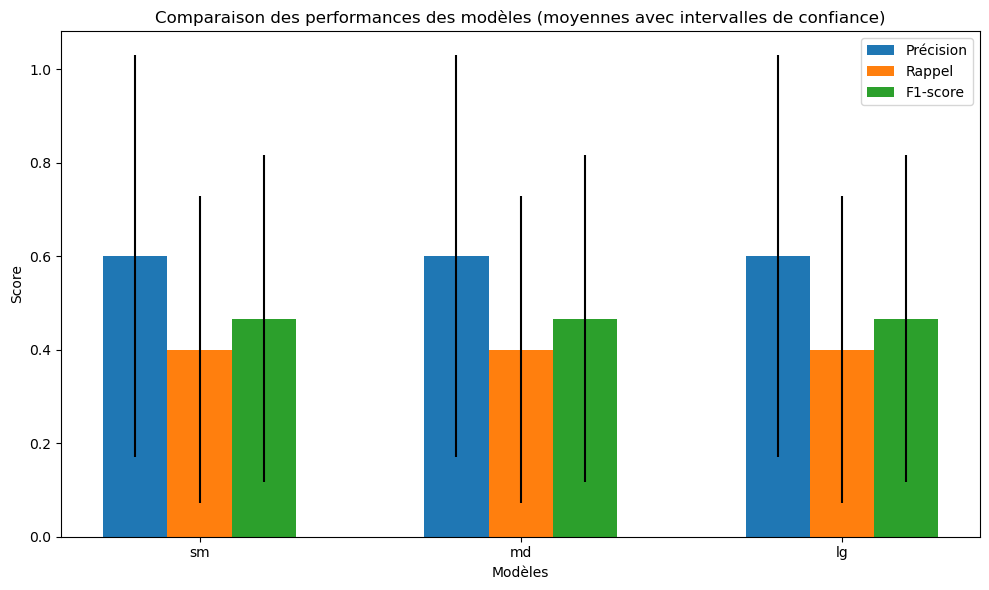

Analyse des erreurs: {'sm': [{'false_positive': [], 'false_negative': []}, {'false_positive': [('.', 'DESTINATION'), ('Réservez', 'DESTINATION')], 'false_negative': [('Marseille', 'DESTINATION'), ('Lille', 'DEPARTURE')]}, {'false_positive': [], 'false_negative': [('Bordeaux', 'DEPARTURE')]}, {'false_positive': [('.', 'ESCALE')], 'false_negative': [('Paris', 'STOP'), ('Nice', 'DESTINATION'), ('Strasbourg', 'DEPARTURE')]}, {'false_positive': [], 'false_negative': [('Lille', 'DESTINATION')]}], 'md': [{'false_positive': [], 'false_negative': []}, {'false_positive': [('.', 'DESTINATION'), ('Réservez', 'DESTINATION')], 'false_negative': [('Marseille', 'DESTINATION'), ('Lille', 'DEPARTURE')]}, {'false_positive': [], 'false_negative': [('Bordeaux', 'DEPARTURE')]}, {'false_positive': [('.', 'ESCALE')], 'false_negative': [('Paris', 'STOP'), ('Nice', 'DESTINATION'), ('Strasbourg', 'DEPARTURE')]}, {'false_positive': [], 'false_negative': [('Lille', 'DESTINATION')]}], 'lg': [{'false_positive': [], 

C:\Users\vikne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\vikne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


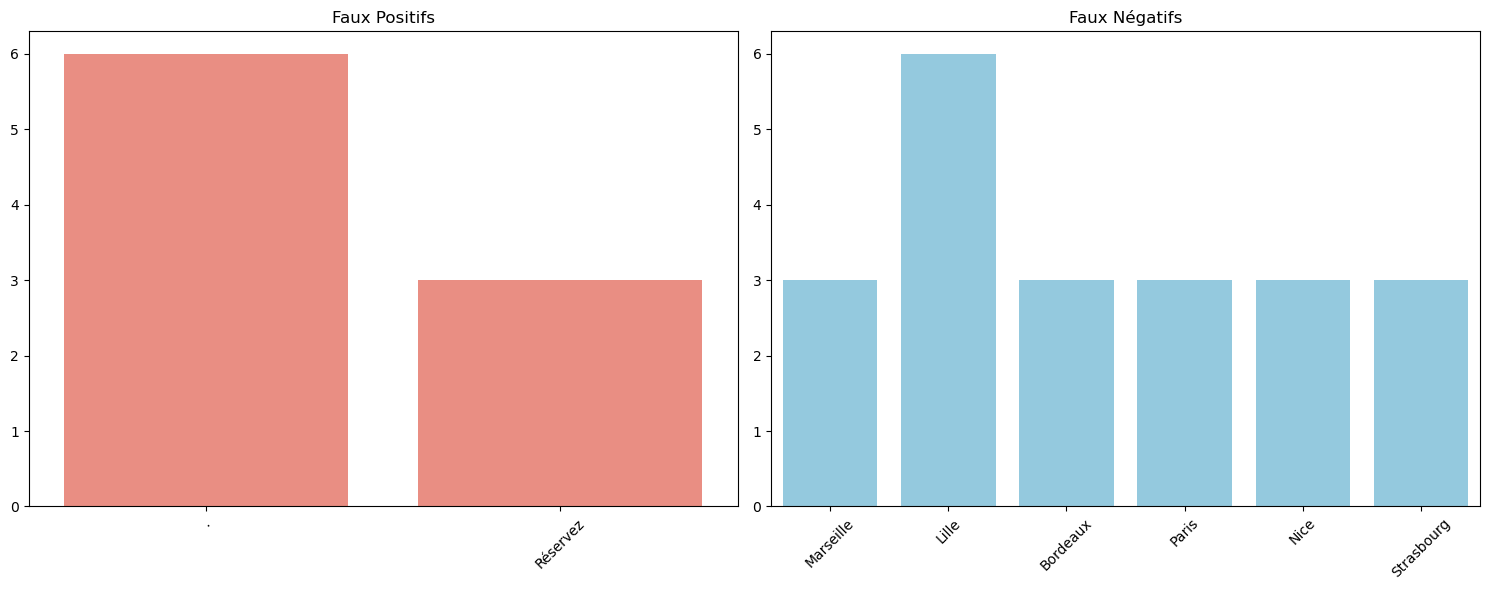

In [1]:
import spacy
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from spacy.tokens import DocBin
from spacy import displacy
import ast
from random import shuffle
import numpy as np
from collections import Counter
import seaborn as sns

print("Librairies importées")

# Chargement des modèles entraînés dans `model_training.ipynb`
models = {
    "sm": "../../models/saved_models/sm/model-best",
    "md": "../../models/saved_models/md/model-best",
    "lg": "../../models/saved_models/lg/model-best"
}

nlp_models = {}
for model_key, model_path in models.items():
    print(f"Chargement du modèle {model_key}...")
    nlp_models[model_key] = spacy.load(model_path)
print("Tous les modèles sont bien chargés.")

# Fonction d'extraction des entités de départ et destination
def extract_entities(doc):
    return [(ent.text, ent.label_) for ent in doc.ents]

# Jeu de données de test pour évaluation élargie
test_texts = [
    "Je veux aller de Paris à Lyon demain.",
    "Réservez-moi un billet de train de Lille à Marseille.",
    "Je pars de Bordeaux et j'arrive à Toulouse en soirée.",
    "Voyage de Strasbourg à Nice avec une escale à Paris.",
    "Quel est le meilleur trajet pour aller de Grenoble à Lille ?"
]

# Annotations de référence pour les textes (prévoyez d'élargir ces annotations)
ground_truths = [
    [('Paris', 'DEPARTURE'), ('Lyon', 'DESTINATION')],
    [('Lille', 'DEPARTURE'), ('Marseille', 'DESTINATION')],
    [('Bordeaux', 'DEPARTURE'), ('Toulouse', 'DESTINATION')],
    [('Strasbourg', 'DEPARTURE'), ('Nice', 'DESTINATION'), ('Paris', 'STOP')],
    [('Grenoble', 'DEPARTURE'), ('Lille', 'DESTINATION')]
]

# Fonction pour évaluer chaque modèle sur un ensemble de textes de test
def evaluate_models(nlp_models, texts, ground_truths):
    results = {key: [] for key in nlp_models.keys()}
    for text in texts:
        for model_key, model in nlp_models.items():
            doc = model(text)
            entities = extract_entities(doc)
            results[model_key].append(entities)
    return results

# Comparaison des résultats extraits et des annotations de référence
def compute_metrics(results, ground_truths):
    metrics = {key: {'precision': [], 'recall': [], 'f1_score': []} for key in results.keys()}
    for model_key, model_results in results.items():
        for predicted, true in zip(model_results, ground_truths):
            true_set = set(true)
            pred_set = set(predicted)
            tp = len(true_set & pred_set)
            fp = len(pred_set - true_set)
            fn = len(true_set - pred_set)

            precision = tp / (tp + fp) if tp + fp > 0 else 0
            recall = tp / (tp + fn) if tp + fn > 0 else 0
            f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

            metrics[model_key]['precision'].append(precision)
            metrics[model_key]['recall'].append(recall)
            metrics[model_key]['f1_score'].append(f1_score)

    # Calcul des moyennes et des intervalles de confiance
    for model_key in metrics:
        for metric in metrics[model_key]:
            metric_scores = metrics[model_key][metric]
            mean_score = np.mean(metric_scores)
            std_error = np.std(metric_scores) / np.sqrt(len(metric_scores))
            confidence_interval = 1.96 * std_error  # Intervalle de confiance 95%
            metrics[model_key][metric] = {
                'mean': mean_score,
                'ci': confidence_interval
            }
            print(f"\nModèle : {model_key}")
            print(f"  {metric.capitalize()} moyenne: {mean_score:.2f} ± {confidence_interval:.2f}")

    return metrics

# Exécution de l'évaluation des modèles
results = evaluate_models(nlp_models, test_texts, ground_truths)
metrics = compute_metrics(results, ground_truths)

# Visualisation avancée des métriques pour chaque modèle avec intervalles de confiance
def plot_metrics(metrics):
    model_names = list(metrics.keys())
    precision_means = [metrics[model]['precision']['mean'] for model in model_names]
    precision_cis = [metrics[model]['precision']['ci'] for model in model_names]
    recall_means = [metrics[model]['recall']['mean'] for model in model_names]
    recall_cis = [metrics[model]['recall']['ci'] for model in model_names]
    f1_means = [metrics[model]['f1_score']['mean'] for model in model_names]
    f1_cis = [metrics[model]['f1_score']['ci'] for model in model_names]

    x = range(len(model_names))

    plt.figure(figsize=(10, 6))
    plt.bar(x, precision_means, width=0.2, label='Précision', yerr=precision_cis, align='center')
    plt.bar([p + 0.2 for p in x], recall_means, width=0.2, label='Rappel', yerr=recall_cis, align='center')
    plt.bar([p + 0.4 for p in x], f1_means, width=0.2, label='F1-score', yerr=f1_cis, align='center')

    plt.xticks([p + 0.2 for p in x], model_names)
    plt.xlabel('Modèles')
    plt.ylabel('Score')
    plt.title('Comparaison des performances des modèles (moyennes avec intervalles de confiance)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(metrics)

# Analyse des erreurs pour visualiser les entités mal classifiées
def error_analysis(results, ground_truths):
    errors = {key: [] for key in results.keys()}
    for model_key, model_results in results.items():
        for predicted, true in zip(model_results, ground_truths):
            true_set = set(true)
            pred_set = set(predicted)
            errors[model_key].append({
                'false_positive': list(pred_set - true_set),
                'false_negative': list(true_set - pred_set)
            })
    return errors

errors = error_analysis(results, ground_truths)
print("Analyse des erreurs:", errors)

# Visualisation des erreurs courantes
def plot_errors(errors):
    error_counts = {'false_positive': Counter(), 'false_negative': Counter()}
    for model_key in errors:
        for error in errors[model_key]:
            error_counts['false_positive'].update([ent for ent, _ in error['false_positive']])
            error_counts['false_negative'].update([ent for ent, _ in error['false_negative']])

    # Graphique des erreurs fausses positives et fausses négatives
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=list(error_counts['false_positive'].keys()), y=list(error_counts['false_positive'].values()), ax=ax[0], color="salmon")
    ax[0].set_title("Faux Positifs")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

    sns.barplot(x=list(error_counts['false_negative'].keys()), y=list(error_counts['false_negative'].values()), ax=ax[1], color="skyblue")
    ax[1].set_title("Faux Négatifs")
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

plot_errors(errors)